# canny_detail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
pic_path = 'lenna.png'
img = plt.imread(pic_path)
if pic_path[-4:] == '.png':
    img = img * 255
img = img.mean(axis=-1)

(-0.5, 511.5, 511.5, -0.5)

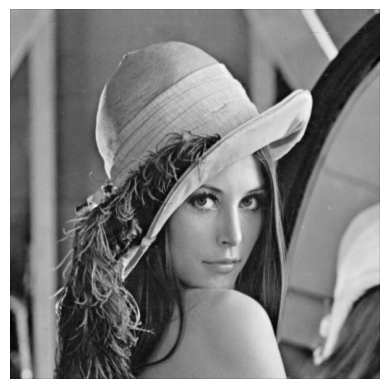

In [3]:
sigma = 0.5
dim = int(np.round(6*sigma + 1))
if dim%2 == 0:
    dim += 1
Gaussian_filter = np.zeros([dim, dim])
tmp = [i-dim//2 for i in range(dim)]
n1 = 1/(2*math.pi*sigma**2)
n2 = -1/(2*sigma**2)
for i in range(dim):
    for j in range(dim):
        Gaussian_filter[i, j] = n1*math.exp(n2*(tmp[i]**2+tmp[j]**2))
Gaussian_filter = Gaussian_filter/Gaussian_filter.sum()
dx, dy = img.shape
img_new = np.zeros(img.shape)
tmp = dim // 2
img_pad = np.pad(img, ((tmp, tmp), (tmp, tmp)), 'constant')
for i in range(dx):
    for j in range(dy):
        img_new[i, j] = np.sum(img_pad[i:i+dim, j:j+dim]*Gaussian_filter)
plt.figure(1)
plt.imshow(img_new.astype(np.uint8), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

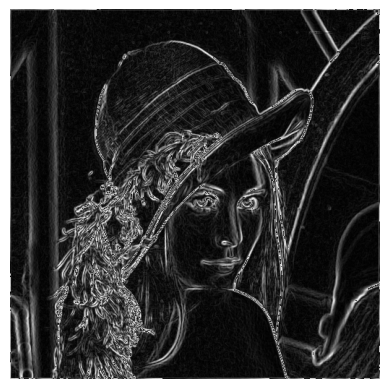

In [4]:
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
grad_x = np.zeros(img_new.shape)
grad_y = np.zeros([dx, dy])
img_grad = np.zeros(img_new.shape)
img_pad = np.pad(img_new, ((1,1), (1,1)), 'constant')
for i in range(dx):
    for j in range(dy):
        grad_x[i, j] = np.sum(img_pad[i:i+3, j:j+3]*sobel_kernel_x)
        grad_y[i, j] = np.sum(img_pad[i:i+3, j:j+3]*sobel_kernel_y)
        img_grad[i, j] = np.sqrt(grad_x[i, j]**2 + grad_y[i, j]**2)
grad_x[grad_x == 0] = 0.00000001
angle = grad_y/grad_x
plt.figure(2)
plt.imshow(img_grad.astype(np.uint8), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

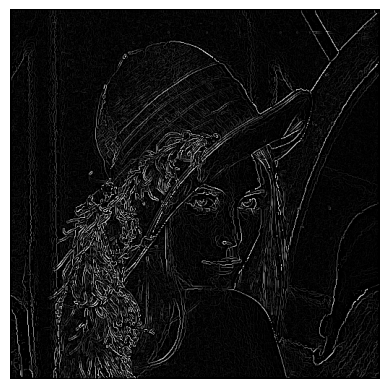

In [5]:
img_nms = np.zeros(img_grad.shape)
for i in range(1, dx-1):
    for j in range(1, dy-1):
        flag = True
        temp = img_grad[i-1:i+2, j-1:j+2]
        if angle[i, j] <= -1:
            num_1 = (temp[0, 1]-temp[0, 0]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 1]-temp[2, 2]) / angle[i, j] + temp[2, 1]
            if not (img_grad[i, j] > num_1 and img_grad[i, j] > num_2):
                flag = False
        elif angle[i, j] >= 1:
            num_1 = (temp[0, 2]-temp[0, 1]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 0]-temp[2, 1]) / angle[i, j] + temp[2, 1]
            if not (img_grad[i, j] > num_1 and img_grad[i, j] > num_2):
                flag = False
        elif angle[i, j] > 0:
            num_1 = (temp[2, 0]-temp[1, 0]) * angle[i, j] + temp[1, 0]
            num_2 = (temp[0, 2]-temp[1, 2]) * angle[i, j] + temp[1, 2]
            if not (img_grad[i, j] > num_1 and img_grad[i, j] > num_2):
                flag = False
        elif angle[i, j] < 0:
            num_1 = (temp[1, 0]-temp[0, 0]) * angle[i, j] + temp[1, 0]
            num_2 = (temp[1, 2]-temp[2, 2]) * angle[i, j] + temp[1, 2]
            if not (img_grad[i, j] > num_1 and img_grad[i, j] > num_2):
                flag = False
        
        if flag:
            img_nms[i, j] = img_grad[i, j]

plt.figure(3)
plt.imshow(img_nms.astype(np.uint8), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

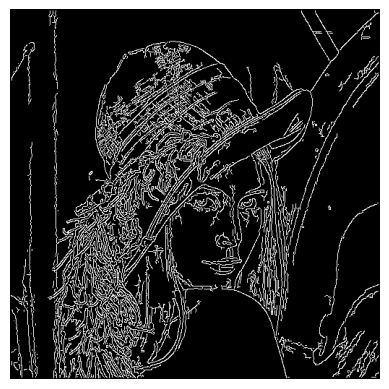

In [6]:
lower_boundary = img_grad.mean()*0.5
high_boundary = lower_boundary*3
stack = []

for i in range(1, img_nms.shape[0]-1):
    for j in range(1, img_nms.shape[1]-1):
        if img_nms[i, j] >= high_boundary:
            img_nms[i, j] = 255
            stack.append([i, j])
        elif img_nms[i, j] <= lower_boundary:
            img_nms[i, j] = 0

while not len(stack) == 0:
    temp_1, temp_2 = stack.pop()
    a = img_nms[temp_1-1:temp_1+2, temp_2-1:temp_2+2]
    if (a[0, 0] < high_boundary) and (a[0, 0] > lower_boundary):
        img_grad[temp_1-1, temp_2-1] = 255
        stack.append([temp_1-1, temp_2-1])
    if (a[0, 1] < high_boundary) and (a[0, 1] > lower_boundary):
        img_nms[temp_1-1, temp_2] = 255
        stack.append([temp_1-1, temp_2])
    if (a[0, 2] < high_boundary) and (a[0, 2] > lower_boundary):
        img_nms[temp_1-1, temp_2+1] = 255
        stack.append([temp_1-1, temp_2+1])
    if (a[1, 0] < high_boundary) and (a[1, 0] > lower_boundary):
        img_nms[temp_1, temp_2-1] = 255
        stack.append([temp_1, temp_2-1])
    if (a[1, 2] < high_boundary) and (a[1, 2] > lower_boundary):
        img_nms[temp_1, temp_2+1] = 255
        stack.append([temp_1, temp_2+1])
    if (a[2, 0] < high_boundary) and (a[2, 0] > lower_boundary):
        img_nms[temp_1+1, temp_2-1] = 255
        stack.append([temp_1+1, temp_2-1])
    if (a[2, 1] < high_boundary) and (a[2, 1] > lower_boundary):
        img_nms[temp_1+1, temp_2] = 255
        stack.append([temp_1+1, temp_2])
    if (a[2, 2] < high_boundary) and (a[2, 2] > lower_boundary):
        img_nms[temp_1+1, temp_2+1] = 255
        stack.append([temp_1+1, temp_2+1])

for i in range(img_nms.shape[0]):
    for j in range(img_nms.shape[1]):
        if img_nms[i, j] != 0 and img_nms[i, j] != 255:
            img_nms[i, j] = 0.5

plt.figure(4)
plt.imshow(img_nms.astype(np.uint8), cmap='gray')
plt.axis('off')

# canny invoked by opencv

In [7]:
import cv2

In [8]:
img = cv2.imread('lenna.png', 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_canny = cv2.Canny(gray, 200, 300)
cv2.imshow('canny', img_canny)
cv2.waitKey()

-1